In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_curve

from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Heart Disease: Classifying the Risk of disease

### Data is collected from UC Irvine Machine Learning Repository!


#### Author: Mariya Tumbeva

## Tasks: Make an appropriate algorithm for recognition of hearth disease

Features Information: 
------------------------ 

1. (age) in years
2. (sex) 1 = male; 0 = female
3. (cp) chest pain type: 4 values: 1 = typical angina; 2 = atypical angina; 3 = non-angina; 4 = asymptomatic angina
4. (trestbps) resting blood pressure in mm Hg
5. (chol) serum cholestoral in mg/dl 
6. (fbs) fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. (restecg) resting electrocardiographic results (3 values: 0 = normal; 1 = having ST-T; 2 = hypertrophy) 
8. (thalach) maximum heart rate achieved 
9. (exang) exercise induced angina (1 = yes; 0 = no)
10. (oldpeak) = ST depression induced by exercise relative to rest 
11. (slope) the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
12. (ca) number of major vessels (0-3) colored by flourosopy 
13. (thal) thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
14. (num) (the predicted attribute)


Features types 
----------------- 

Real: 1,4,5,8,10,12 

Ordered:11, 

Binary: 2,6,9 

Nominal:7,3,13 


Variable to be predicted 
------------------------ 
Absence (1: red) or presence (2: blue) of heart disease 


In [3]:
heart_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat", header = None, sep=" ")
heart_data.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [4]:
heart_data.shape

(270, 14)

In [5]:
heart_data['cp'] = heart_data['cp'].astype('category')
heart_data['restecg'] = heart_data['restecg'].astype('category')
heart_data['slope'] = heart_data['slope'].astype('category')
heart_data['thal'] = heart_data['thal'].astype('category')

In [6]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
age         270 non-null float64
sex         270 non-null float64
cp          270 non-null category
trestbps    270 non-null float64
chol        270 non-null float64
fbs         270 non-null float64
restecg     270 non-null category
thalach     270 non-null float64
exang       270 non-null float64
oldpeak     270 non-null float64
slope       270 non-null category
ca          270 non-null float64
thal        270 non-null category
target      270 non-null int64
dtypes: category(4), float64(9), int64(1)
memory usage: 22.7 KB


In [7]:
heart_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
trestbps,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
chol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
fbs,270.0,0.148148,0.355906,0.0,0.0,0.0,0.0,1.0
thalach,270.0,149.677778,23.165717,71.0,133.0,153.5,166.0,202.0
exang,270.0,0.329630,0.470952,0.0,0.0,0.0,1.0,1.0
oldpeak,270.0,1.050000,1.145210,0.0,0.0,0.8,1.6,6.2
ca,270.0,0.670370,0.943896,0.0,0.0,0.0,1.0,3.0
target,270.0,1.444444,0.497827,1.0,1.0,1.0,2.0,2.0


In [8]:
with_disease = heart_data[heart_data.target == 2].shape[0]
wo_disease = heart_data[heart_data.target == 1].shape[0]
print("people with disease:", with_disease)
print("people wo disease:", wo_disease)

people with disease: 120
people wo disease: 150


In [9]:
def pairwise_correlation_pearson(dataframe):
    d_corr_p = dataframe.drop(['target', 'sex', 'fbs', 'exang'], axis=1).corr(method='pearson')
    return d_corr_p

In [10]:
corr = pairwise_correlation_pearson(heart_data)
corr.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('Oranges'), axis=0)

,age,trestbps,chol,thalach,oldpeak,ca
age,1.0,0.27,0.22,-0.4,0.19,0.36
trestbps,0.27,1.0,0.17,-0.039,0.22,0.086
chol,0.22,0.17,1.0,-0.019,0.028,0.13
thalach,-0.4,-0.039,-0.019,1.0,-0.35,-0.27
oldpeak,0.19,0.22,0.028,-0.35,1.0,0.26
ca,0.36,0.086,0.13,-0.27,0.26,1.0


Observation of correlation coefficients shows that there are not strong relation between features. Шheare is a conservative estimate between:
- positive: age and (ca) number of major vessels (0-3) colored by flourosopy -> 0.36
- negative: age and (thalach) maximum heart rate achieved -> -0.40
- positive: age and (trestbps) resting blood pressure in mm Hg -> 0.27
- negative: oldpeak and (thalach) maximum heart rate achieved -> -0.35

In [11]:
d10 = heart_data.age[heart_data.target == 1]
d11 = heart_data.age[heart_data.target == 2]
d20 = heart_data.sex[heart_data.target == 1]
d21 = heart_data.sex[heart_data.target == 2]
d30 = heart_data.cp[heart_data.target == 1]
d31 = heart_data.cp[heart_data.target == 2]
d40 = heart_data.trestbps[heart_data.target == 1]
d41 = heart_data.trestbps[heart_data.target == 2]
d50 = heart_data.chol[heart_data.target == 1]
d51 = heart_data.chol[heart_data.target == 2]
d60 = heart_data.fbs[heart_data.target == 1]
d61 = heart_data.fbs[heart_data.target == 2]
d70 = heart_data.restecg[heart_data.target == 1]
d71 = heart_data.restecg[heart_data.target == 2]
d80 = heart_data.thalach [heart_data.target == 1]
d81 = heart_data.thalach [heart_data.target == 2]
d90 = heart_data.exang[heart_data.target == 1]
d91 = heart_data.exang[heart_data.target == 2]
d100 = heart_data.oldpeak[heart_data.target == 1]
d101 = heart_data.oldpeak[heart_data.target == 2]
d110 = heart_data.ca[heart_data.target == 1]
d111 = heart_data.ca[heart_data.target == 2]
d120 = heart_data.thal[heart_data.target == 1]
d121 = heart_data.thal[heart_data.target == 2]
d130 = heart_data.slope[heart_data.target == 1]
d131 = heart_data.slope[heart_data.target == 2]

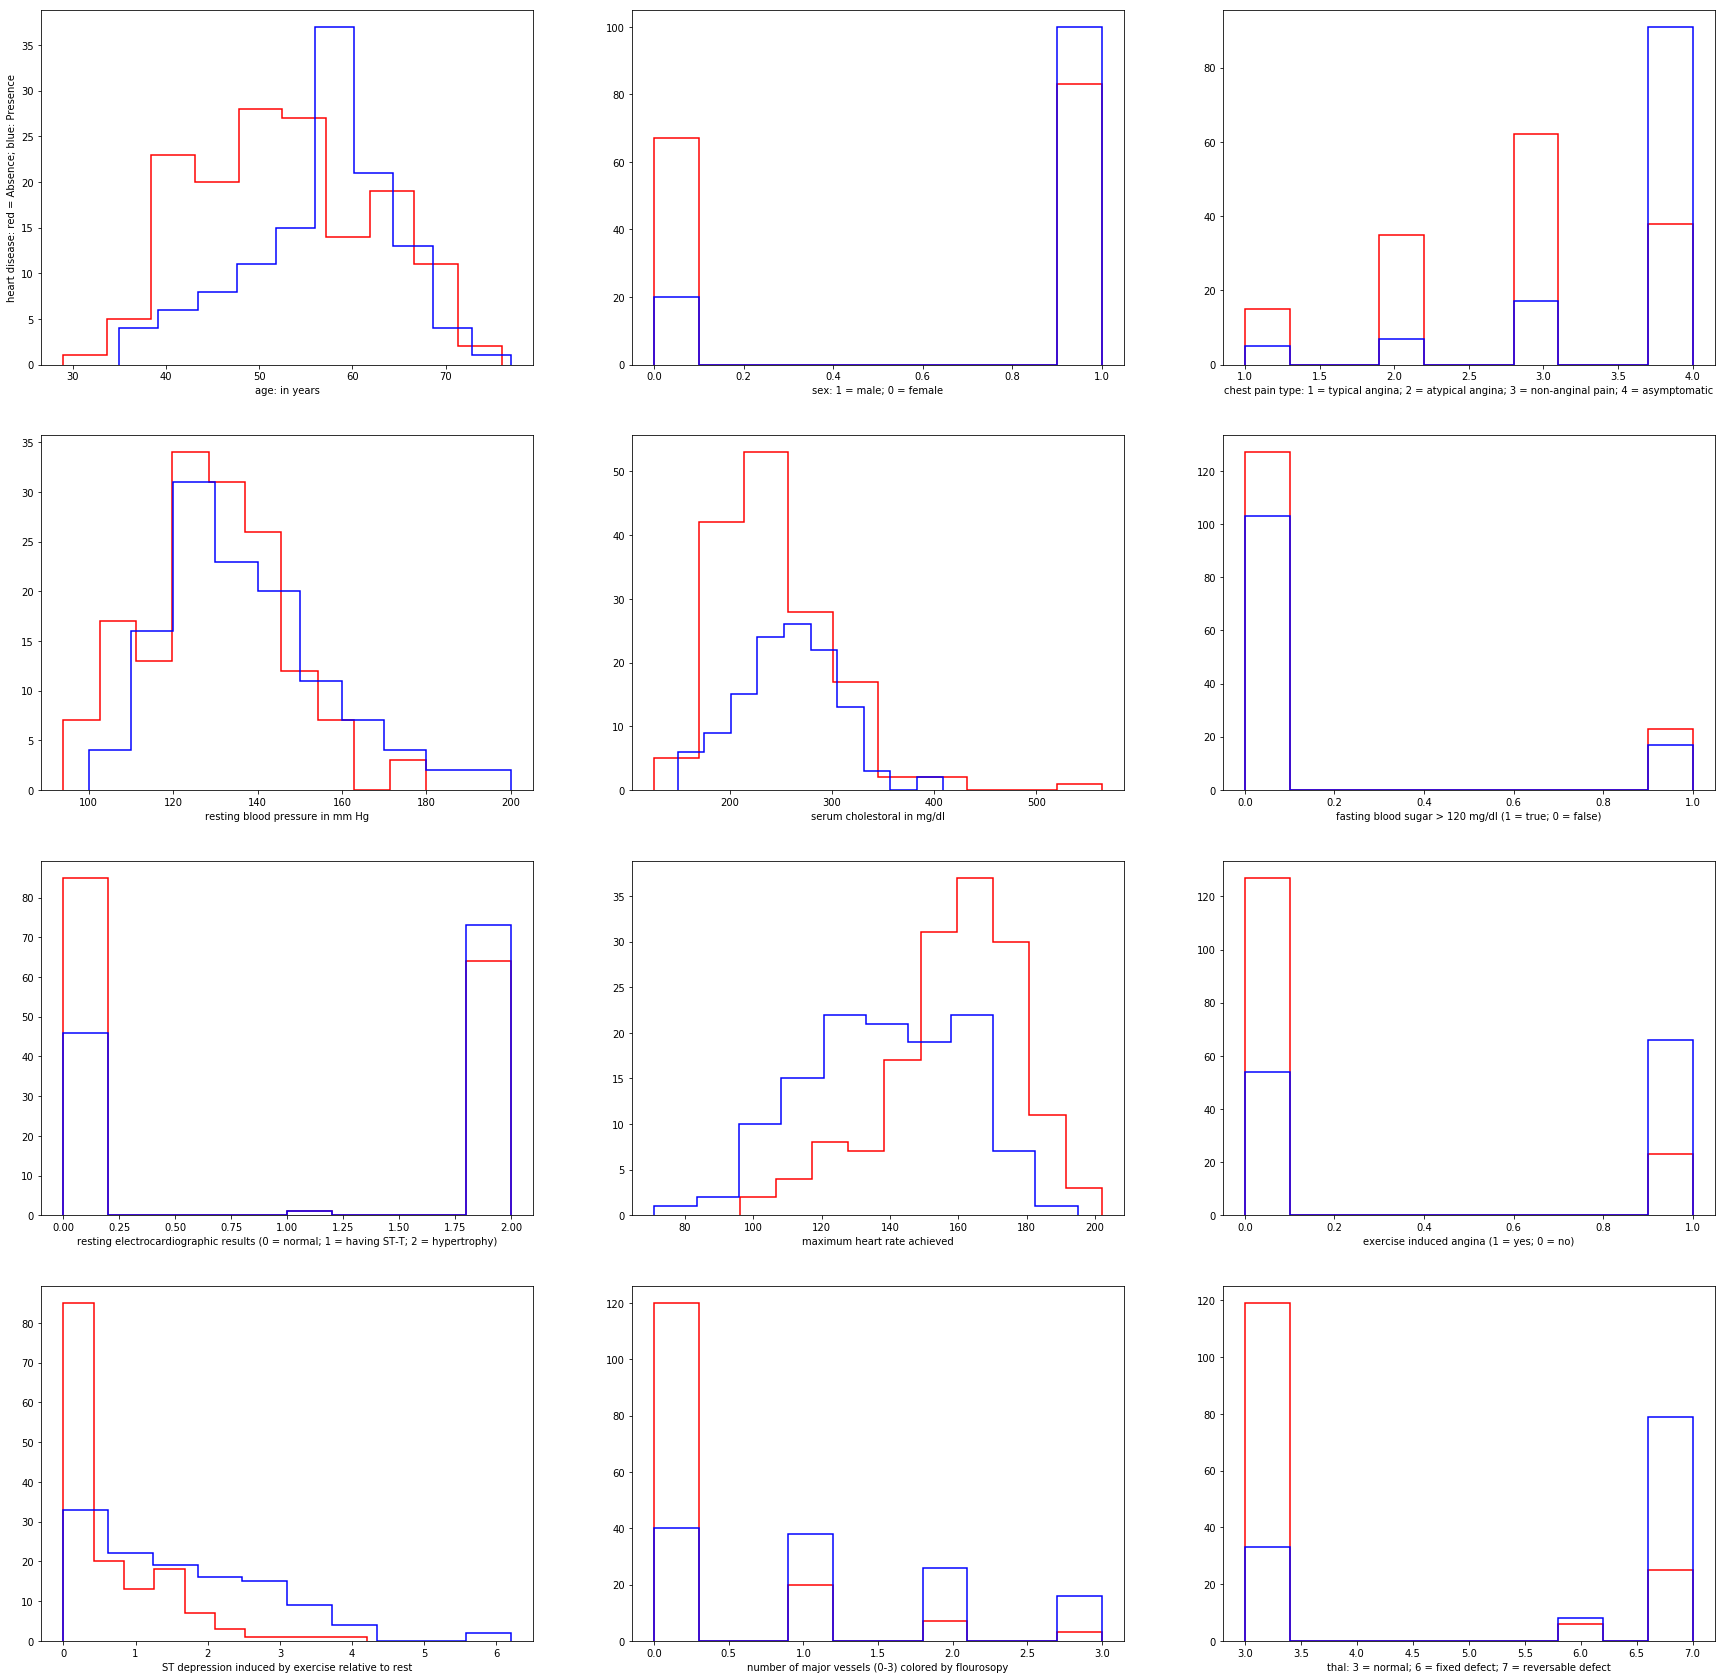

In [12]:
plt.rcParams['figure.figsize'] = [30, 30]

fig, axes = plt.subplots(nrows=4, ncols=3)

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11= axes.flatten()

ax0.hist(d10, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax0.hist(d11, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax0.set_xlabel("age: in years")
ax0.set_ylabel("heart disease: red = Absence; blue: Presence")

ax1.hist(d20, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax1.hist(d21, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax1.set_xlabel("sex: 1 = male; 0 = female")

ax2.hist(d30, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax2.hist(d31, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax2.set_xlabel("chest pain type: 1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic")

ax3.hist(d40, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax3.hist(d41, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax3.set_xlabel("resting blood pressure in mm Hg")

ax4.hist(d50, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax4.hist(d51, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax4.set_xlabel("serum cholestoral in mg/dl")

ax5.hist(d60, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax5.hist(d61, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax5.set_xlabel("fasting blood sugar > 120 mg/dl (1 = true; 0 = false)")

ax6.hist(d70, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax6.hist(d71, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax6.set_xlabel("resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)")

ax7.hist(d80, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax7.hist(d81, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax7.set_xlabel("maximum heart rate achieved")

ax8.hist(d90, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax8.hist(d91, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax8.set_xlabel("exercise induced angina (1 = yes; 0 = no)")

ax9.hist(d100, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax9.hist(d101, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax9.set_xlabel("ST depression induced by exercise relative to rest")

ax10.hist(d110, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax10.hist(d111, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax10.set_xlabel("number of major vessels (0-3) colored by flourosopy")

ax11.hist(d120, 10, ec='red', fc='none', lw=1.5, histtype='step')
ax11.hist(d121, 10, ec='blue', fc='none', lw=1.5, histtype='step')
ax11.set_xlabel("thal: 3 = normal; 6 = fixed defect; 7 = reversable defect")

#ax12.hist(d130, 10, ec='red', fc='none', lw=1.5, histtype='step', label='Absence of heart disease ')
#ax12.hist(d131, 10, ec='blue', fc='none', lw=1.5, histtype='step', label='Presence of heart disease ')
#ax12.set_xlabel("the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)")

plt.show()

Charts of the features in the heart disease data set, for patients with (red) and without (blue) the disease shows that: 

- people with heart disease tend to be older and male. (~56y m with d vs ~51y m wo d; ~59y m with d vs ~54y m wo d - womant with disease are older than man).;

- have higher blood pressure;

- have higher cholesterol levels;

- have lower maximum heart rate under the Thalium stress test 

- have symptomatic chest pain type. They tend to had exercise induced angina and thal ~ == "fixed defect"

- Womens with symptomatic chest pain type have significantly high blood presure (~149 w vs. ~ 131 m) and extremely high cholesterol (290 w vs. ~250 m)


than people without disease. 


(cp) chest pain type: 

- 1 = typical angina: Стабилна ангина. Болката може да се предвиди. Появява се по време на физически упражнения и състояние на екстремен емоционален дистрес.

- 2 = atypical angina: Нестабилна ангина. Възприема се като признак за предстояща сърдечна атака. Болката при нестабилната ангина е различна от болките в гърдите, които обикновено се изпитват от страдащите от стенокардия.
Ангината се среща по-често в състояние на покой, силно и продължително. Въпреки че състоянието се овладява с прием на медикаменти, то е нестабилно и може да прогресира в сърдечна атака. Налага се по-интензивна медикаментозна терапия или специални процедури.

- 3 = non-angina: Атипична ангина (Prinzmetal). Появява се в състояние на покой, по време на сън или излагане на ниски температури. В този случаи симптомите са причинени от намален приток на кръв към сърцето и спазъм на коронарната артерия.
По-голяма част от пациентите с това заболяване страдат и от коронарно 

- 4 = asymptomatic angina: заболяване. Мускулният спазъм може да доведе до блокаж на притока на кръв.


(exang) exercise induced angina: Коронарна болест - отпусване на артериите; байпаси


(thal) Таласемия - най-тежката анемия

(restec) resting electrocardiographic results: 1 = having ST-T (Нарушения в камерната реполаризация - предиктор за смърт); 2 = hypertrophy (уголемяване на сърдечния мускул)

# Use a regression models to classify: 

Following algorithms will work correctly with the categorical variables, without additional settings: Logistic regression, Decision tree, Random forest, AdaBoost and others.

## Logistic Regression

In [13]:
heart_features = heart_data.drop("target", axis = 1) 
heart_output = heart_data["target"] 

In [14]:
heart_features_train, heart_features_test, heart_output_train, heart_output_test = train_test_split(heart_features, 
                                                                                                    heart_output, 
                                                                                                    train_size = 0.7, 
                                                                                                    test_size = 0.3)#, random_state=0)

In [15]:
print("heart_features_train:", heart_features_train.shape)
print("heart_output_train:", heart_output_train.shape)
print("heart_features_test:", heart_features_test.shape)
print("heart_output_test:", heart_output_test.shape)

heart_features_train: (189, 13)
heart_output_train: (189,)
heart_features_test: (81, 13)
heart_output_test: (81,)


For logistic regression its important following things:
- Binary Output Variable: logistic regression is intended for binary classification problems. It will predict the probability of an instance belonging to the default class, which can be snapped into a 0 or 1 classification.
- Logistic regression assumes no error in the output variable (y).
- Gaussian Distribution: Logistic regression is a linear algorithm (with a non-linear transform on output). It does assume a linear relationship between the input variables with the output. 
- Remove Correlated Inputs: the model can overfit if you have multiple highly-correlated inputs. Consider calculating the pairwise correlations between all inputs and removing highly correlated inputs.

Regularization does not improve the performance on the data set that the algorithm used to learn the model parameters. However, it can improve the performance on new, unseen data.

In our case we can think of regularization of increasing the bias, because the model suffers from (high) variance (i.e., it overfits the training data). On the other hand, too much bias will result in underfitting (a characteristic indicator of high bias is that the model shows a "bad" performance for both the training and test dataset). We know that our goal in an unregularized model is to minimize the cost function, i.e., we want to find the feature weights that correspond to the global cost minimum.

The results shows high regularization (parameter C is small), score is OK (about 90%).
In case of overfitting the model just tries to learn pecularities of the training set and does not work well on unseen examples that differ from the training set. In our case, model is performing well in both - training and inseen examples.

In [16]:
tuned_params = [{"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e6], 
                 "max_iter": [1, 5, 10, 20, 30, 50, 100, 300, 1000],
                 "fit_intercept": [True,False]}]
grid_search = GridSearchCV(LogisticRegression(), tuned_params, scoring = "f1" )
best_model = grid_search.fit(heart_features_train, heart_output_train)
best_params_ = best_model.best_estimator_.get_params()
y_pred = best_model.predict_proba(heart_features_test)[:, 1]
score = best_model.score(heart_features_test, heart_output_test)
precision, recall, _ = roc_curve(heart_output_test, y_pred, pos_label = 2)
print("Best params:", best_params_)
print("Best score:", round(grid_search.best_score_, 3))
print("Score:", round(score, 3))

Best params: {'C': 1000, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'max_iter': 10, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best score: 0.862
Score: 0.86


When we make a binary prediction, there can be 4 types of errors:

We predict 0 while we should have the class is actually 0: this is called a True Negative, i.e. we correctly predict that the class is negative (0). In our case, did not detect a disease.

We predict 0 while we should have the class is actually 1: this is called a False Negative, i.e. we incorrectly predict that the class is negative (0). In our case, failed to detect a disease.

We predict 1 while we should have the class is actually 0: this is called a False Positive, i.e. we incorrectly predict that the class is positive (1). In our case, considered detect a disease.

We predict 1 while we should have the class is actually 1: this is called a True Positive, i.e. we correctly predict that the class is positive (1). In our case, rightfully detected a disease.

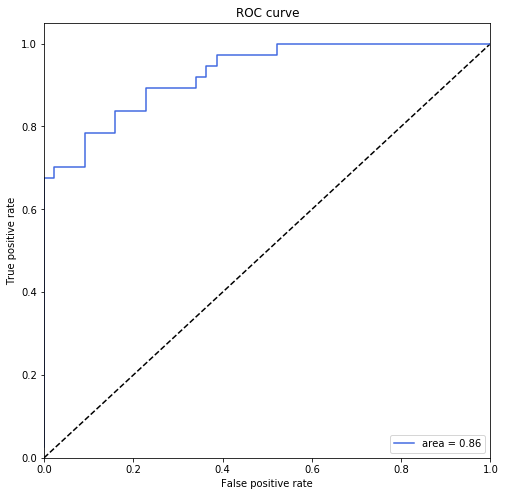

In [17]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.plot([0, 1], [0, 1], "k--")
plt.plot(precision, recall, color="royalblue", label="area = %0.2f" % score)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

True positive rate (TPR), hit rate, and recall, which is defined as TPTP+FN. 

Intuitively this metric corresponds to the proportion of positive data points that are correctly considered as positive, with respect to all positive data points. 

In other words, the higher TPR, the fewer positive data points we will miss.


False positive rate (FPR), which is defined as FPFP+TN. 

Intuitively this metric corresponds to the proportion of negative data points that are mistakenly considered as positive, with respect to all negative data points. 

In other words, the higher FPR, the more negative data points we will missclassified.

The resulting curve of combine the FPR and the TPR into one single metric is called ROC curve

## DecisionTreeClassifier

#### The DecisionTreeClassifier model by itself

Some advantages of decision trees are:

- Simple to understand and to interpret. Trees can be visualised.
- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
- Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable. 
- Able to handle multi-output problems.
- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

When we construct a decision tree, we split the features based on the information gain.

In [18]:
model_dt = DecisionTreeClassifier().fit(heart_features_train, heart_output_train )
y_pred_dt = model_dt.predict_proba(heart_features_test)[:, 1]
score_dt = model_dt.score(heart_features_test, heart_output_test )
precision_dt, recall_dt, _ = roc_curve(heart_output_test, y_pred_dt, pos_label = 2)
print(round(score_dt,3))

0.691


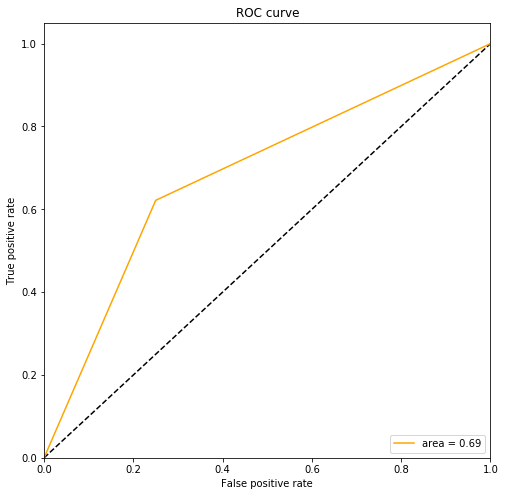

In [19]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(precision_dt, recall_dt, color="orange", label='area = %0.2f' % score_dt)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## KFold with The DecisionTreeClassifier

In [20]:
kfold = StratifiedKFold(n_splits=5).split(heart_features_train, heart_output_train)
params = [{"max_depth": [1, 5, 7, 15, 20], 
                 "min_samples_leaf": [2, 5, 10], 
                 "max_leaf_nodes":[5, 10, 20, 30]}]
grid_search_kfold = GridSearchCV(DecisionTreeClassifier(), params, cv = kfold, scoring = "f1")
best_model_kfold = grid_search_kfold.fit(heart_features_train, heart_output_train)
best_kfold_params_ = grid_search_kfold.best_estimator_.get_params()
y_pred_kfold = best_model_kfold.predict_proba(heart_features_test)[:, 1]
score_kfold = best_model_kfold.score(heart_features_test, heart_output_test)
precision_kfold, recall_kfold, _ = roc_curve(heart_output_test, y_pred_kfold, pos_label = 2)
print("Best params:", best_kfold_params_)
print("Best score:", round(grid_search_kfold.best_score_, 3))
print("Score:", round(score_kfold, 3))

Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
Best score: 0.812
Score: 0.832


When an algorithm has much lower training set error than test set error, it suffers from high variance.

The disadvantages of decision trees include:

- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

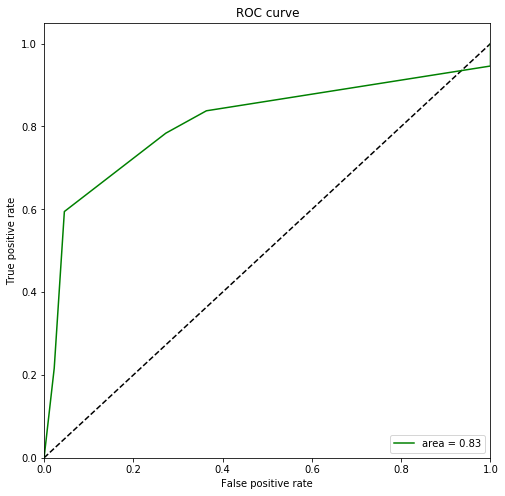

In [21]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(precision_kfold, recall_kfold, color="green", label='area = %0.2f' % score_kfold)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## KFold with The RandomForestClassifier

Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.

This works well because a single decision tree may be prone to a noise, but aggregate of many decision trees reduce the effect of noise giving more accurate results.
The subsets in different decision trees created may overlap

Basic parameters to Random Forest Classifier can be total number of trees to be generated: n_estimators.

In [22]:
kfold = StratifiedKFold(n_splits=10).split(heart_features_train, heart_output_train)
params = [{"n_estimators": [5, 10, 20, 50, 100],
           "max_depth": [5, 10]}]
grid_search_rf = GridSearchCV(RandomForestClassifier(), params, cv = kfold, scoring = "f1")
best_model_rf = grid_search_rf.fit(heart_features_train, heart_output_train)
best_rf_params_ = grid_search_rf.best_estimator_.get_params()
y_pred_rf = best_model_rf.predict_proba(heart_features_test)[:, 1]
score_rf = best_model_rf.score(heart_features_test, heart_output_test)
precision_rf, recall_rf, _ = roc_curve(heart_output_test, y_pred_rf, pos_label = 2)
print("Best params:", best_rf_params_)
print("Best score:", round(grid_search_rf.best_score_, 3))
print("Score:", round(score_rf, 3))

Best params: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best score: 0.863
Score: 0.907


Number of trees the bigger, the better. You almost can't overshoot with this parameter, but of course the upper limit depends on the computational time you want to spend on RandomForestClassifier.


Number of tried attributes the default is square root of the whole number of attributes, yet usually the forest is not very sensitive about the value of this parameter -- in fact it is rarely optimized, especially because stochastic aspect of RandomForestClassifier may introduce larger variations.

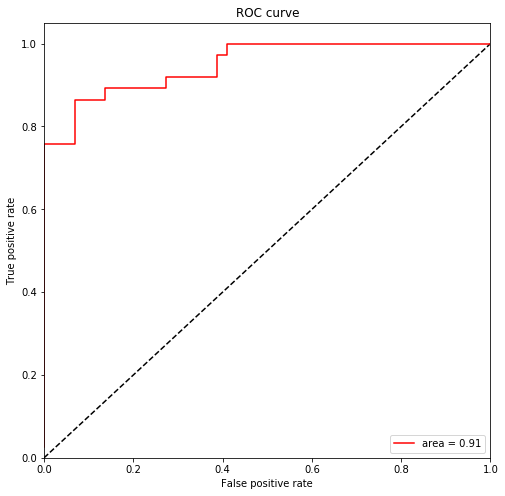

In [23]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(precision_rf, recall_rf, color="red", label='area = %0.2f' % score_rf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
target_1 = f1_score(heart_output_test, grid_search_rf.best_estimator_.predict(heart_features_test), pos_label=1)
target_2 = f1_score(heart_output_test, grid_search_rf.best_estimator_.predict(heart_features_test), pos_label=2)

print("no disease:", round(target_1, 3))
print("disease:", round(target_2, 3))
print("best_params_:", grid_search_rf.best_params_  )
print("best_score_:", round(grid_search_rf.best_score_ , 3))

no disease: 0.907
disease: 0.862
best_params_: {'max_depth': 5, 'n_estimators': 50}
best_score_: 0.863


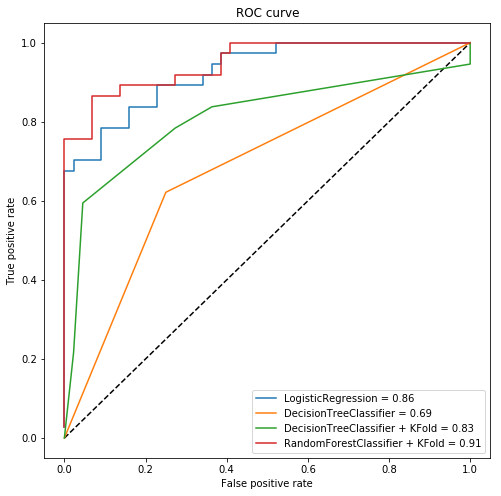

In [25]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(precision, recall, label=('LogisticRegression = %0.2f' % score))
plt.plot(precision_dt, recall_dt, label=('DecisionTreeClassifier = %0.2f' % score_dt ))
plt.plot(precision_kfold, recall_kfold, label=('DecisionTreeClassifier + KFold = %0.2f' % score_kfold))
plt.plot(precision_rf, recall_rf, label=('RandomForestClassifier + KFold = %0.2f' % score_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The ROC curve shows that the best algorithm again is to perform Logistic Regression on this dataset. 

# Feature transformations with ensembles of trees

An ensemble is just a collection of all predictions to give a final prediction. The reason we use ensembles is that many different predictors trying to predict same target variable will perform a better job than any single predictor alone. Ensembling techniques are further classified into Bagging and Boosting.

First fit an ensemble of trees: totally random trees, a random forest, or gradient boosted trees on the training set bu first will trained a linear model.

Then each leaf of each tree in the ensemble is assigned a fixed arbitrary feature index in a new feature space. These leaf indices are then encoded in a one-hot fashion.

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. We use one hot encoder to perform “binarization” of the category and include it as a feature to train the model.

It is important to train the ensemble of trees on a different subset of the training data than the linear regression model to avoid overfitting, in particular if the total number of leaves is similar to the number of training samples.

Each sample goes through the decisions of each tree of the ensemble and ends up in one leaf per tree. The sample is encoded by setting feature values for these leaves to 1 and the other feature values to 0.

The resulting transformer has then learned a supervised, sparse, high-dimensional categorical embedding of the data.

Boosting is an ensemble technique in which the predictors are not made independently, but sequentially.

This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. Therefore, the observations have an unequal probability of appearing in subsequent models and ones with the highest error appear most. The predictors can be chosen from a range of models like decision trees, regressors, classifiers etc. Because new predictors are learning from mistakes committed by previous predictors, it takes less time/iterations to reach close to actual predictions. But we have to choose the stopping criteria carefully or it could lead to overfitting on training data. Gradient Boosting is an example of boosting algorithm.

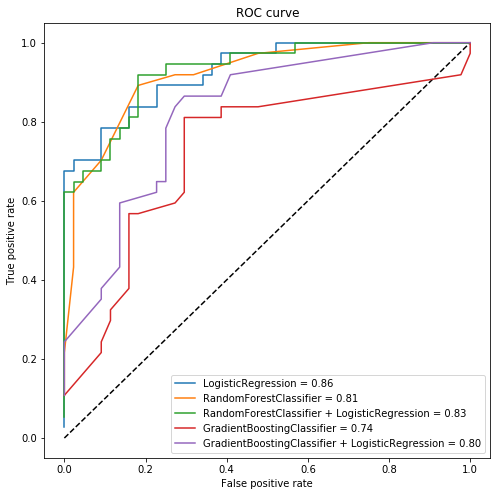

In [26]:
# Unsupervised transformation based on totally random trees
n_estimator = 10
rt = RandomTreesEmbedding(max_depth=5, n_estimators=n_estimator, random_state=0)

heart_features_train, heart_features_train_lr, heart_output_train, heart_output_train_lr = train_test_split(heart_features_train, heart_output_train, test_size=0.7, random_state=0)

#rt_lm = LogisticRegression()
pr, r, _ = roc_curve(heart_output_test, y_pred, pos_label = 2)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(heart_features_train, heart_output_train)
rf_enc.fit(rf.apply(heart_features_train))
rf_lm.fit(rf_enc.transform(rf.apply(heart_features_train_lr)), heart_output_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(heart_features_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(heart_output_test, y_pred_rf_lm, pos_label = 2)
score_rf_lm = rf_lm.score(rf_enc.transform(rf.apply(heart_features_test)), heart_output_test)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(heart_features_train, heart_output_train)
grd_enc.fit(grd.apply(heart_features_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(heart_features_train_lr)[:, :, 0]), heart_output_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(heart_features_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(heart_output_test, y_pred_grd_lm, pos_label = 2)
score_grd_lm = grd_lm.score(grd_enc.transform(grd.apply(heart_features_train_lr)[:, :, 0]), heart_output_train_lr)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(heart_features_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(heart_output_test, y_pred_grd, pos_label = 2)
score_grd = grd.score(heart_features_test, heart_output_test)


# The random forest model by itself
y_pred_rf = rf.predict_proba(heart_features_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(heart_output_test, y_pred_rf, pos_label = 2)
score_rf = rf.score(heart_features_test, heart_output_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(pr, r, label=('LogisticRegression = %0.2f' % score))
plt.plot(fpr_rf, tpr_rf, label=('RandomForestClassifier = %0.2f' % score_rf))
plt.plot(fpr_rf_lm, tpr_rf_lm, label=('RandomForestClassifier + LogisticRegression = %0.2f' % score_rf_lm ))
plt.plot(fpr_grd, tpr_grd, label=('GradientBoostingClassifier = %0.2f' % score_grd))
plt.plot(fpr_grd_lm, tpr_grd_lm, label=('GradientBoostingClassifier + LogisticRegression = %0.2f' % score_grd_lm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The ROC curve shows that the best algorithm again is to perform Logistic Regression on this dataset. 

Features in datase are not correllated but inside there are big variance and with Logistic Regression we perform better results.

As we know using a value that is too small may lead to overfitting and in our case we have a small dataset.

But with a certain confidence we can assumed, that with ~85-90% accuracy we will predict accuratelly what class will be the next input.

The real problem here is that we talk about hearth disease and it will be fatal in some cases. Because of that i stringly recomended to use another dataset, or increase this with more cases and to choose a best algorithm for finding may be earlier incoming hearth disease.